In [77]:
import pandas as pd
from baselines.notears.notears import utils as ut
import numpy as np

summary_csv = pd.DataFrame(columns=["e", "n", "d", "s", "graph", "dtype", "baseline", "etrue", "espur", "emiss", "efals"])

In [78]:
def true_markov_blanket(adj_matrix, var_idx):
    parents = np.where(adj_matrix[:, var_idx])[0].tolist()
    children = np.where(adj_matrix[var_idx])[0].tolist()
    
    spouses = set()
    for c in children:
        for sp in np.where(adj_matrix[:, c])[0]:
            spouses.add(sp)
    
    pa_sp = list(set(parents)&spouses - set(parents) - set([var_idx]))
    ch_sp = list(set(children)&spouses - set(children) - set([var_idx]))
    spouses = list(spouses - set(pa_sp) - set(ch_sp) - set([var_idx]))
    
    return parents, pa_sp, spouses, ch_sp, children

def to_list(all_vars, mb_idx_list):
    return [all_vars[i] for i in mb_idx_list]

In [79]:
from utils.plot_utils import true_edge, spur_edge, fals_edge, miss_edge

def evaluate(B_true, adj_mtx):
    etrue = true_edge(B_true, adj_mtx)
    espur = spur_edge(B_true, adj_mtx)
    efals = fals_edge(B_true, adj_mtx)
    emiss = miss_edge(B_true, adj_mtx)
    return len(etrue), len(espur), len(emiss), len(efals)

#### Generate data using code from Notears

In [80]:
from causallearn.search.ConstraintBased.CDNOD import cdnod
from baselines.FL_FedCDH.mycausallearn.utils.data_utils import get_cpdag_from_cdnod, get_dag_from_pdag
from causallearn.utils.cit import fisherz


for j in [0.1, 0.2, 0.4, 0.6, 0.8]:

    ut.set_random_seed(2025)
    n, d, s0, graph_type, sem_type = 1000, int(100 * j), int(100 * j), 'ER', 'logistic'
    B_true = ut.simulate_dag(d, s0, graph_type)
    W_true = ut.simulate_parameter(B_true)

    n_env = 10
    datas = []
    for i in range(n_env):
        ut.set_random_seed(i**2 +1)
        X = ut.simulate_linear_sem(W_true, n, sem_type)
        datas.append(X)
    all_vars = [f'X{i+1}' for i in range(d)]
    
    c_indx = np.repeat(range(1, n_env + 1), n).reshape(-1, 1).astype(float)
    cg = cdnod(np.concatenate(datas), c_indx, 0.05, fisherz)
    est_graph = cg.G.graph[0:len(all_vars), 0:len(all_vars)]
    est_cpdag = get_cpdag_from_cdnod(est_graph) # est_graph[i,j]=-1 & est_graph[j,i]=1  ->  est_graph_cpdag[i,j]=1
    est_dag_from_pdag = get_dag_from_pdag(est_cpdag) # return a DAG from a PDAG in causaldag
    adj_mtx = get_dag_from_pdag(est_cpdag) # return a DAG from a PDAG in causaldag
    
    etrue, espur, emiss, efals = evaluate(B_true, adj_mtx)    
    summary_csv.loc[-1] = [n_env, n, d, s0, graph_type, sem_type, "CDNOD", etrue, espur, emiss, efals]
    summary_csv.index = summary_csv.index + 1
    summary_csv = summary_csv.sort_index()
    
    print(j, "Done!")

  0%|          | 0/11 [00:00<?, ?it/s]

0.1 Done!


  0%|          | 0/21 [00:00<?, ?it/s]

0.2 Done!


  0%|          | 0/41 [00:00<?, ?it/s]

0.4 Done!


  0%|          | 0/61 [00:00<?, ?it/s]

0.6 Done!


  0%|          | 0/81 [00:00<?, ?it/s]

0.8 Done!


In [5]:
# summary_csv.to_csv("federated-2.csv", index=False)

#### Proposal

In [125]:
# for j in range(1,5+1):
j = 0.8

ut.set_random_seed(2025)
n, d, s0, graph_type, sem_type = 1000, int(100 * j), int(100 * j), 'ER', 'logistic'
B_true = ut.simulate_dag(d, s0, graph_type)
W_true = ut.simulate_parameter(B_true)

n_env = 10
datas = []
for i in range(n_env):
    ut.set_random_seed(i**2 +1)
    X = ut.simulate_linear_sem(W_true, n, sem_type)
    datas.append(X)
all_vars = [f'X{i+1}' for i in range(d)]

In [126]:
from utils.upgrade import compute_mll
from proposal import get_potential_parents, find_connectivity
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

# discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform', subsample=2000)
# silos_data = [pd.DataFrame(discretizer.fit_transform(data), columns=all_vars) for data in datas]
# merged_df = pd.concat(silos_data)
merged_df = pd.DataFrame(np.concatenate(datas), columns=all_vars)

In [127]:
markov_blankets = {var: [] for var in all_vars}

for var in markov_blankets.keys():
    pa, pa_sp, sp, ch_sp, ch = true_markov_blanket(B_true, int(var[1:]) - 1)
    markov_blankets[var] = list(set(to_list(all_vars, pa + pa_sp + sp + ch_sp + ch)) - set([var]))

In [128]:
def compute_variance_viaindexesv2(indexes: list, variable: str, parents: list):
    conditional_probs_record = merged_df[parents + [variable]].groupby(parents + [variable]).count().reset_index()
    mll_list = []
    env = 0
    for index in indexes:
        vertical_sampled_data = merged_df.iloc[index].reset_index()
        vertical_sampled_data = vertical_sampled_data.drop(columns=['index'])
        vertical_sampled_data.insert(0, 'count', [1] * len(vertical_sampled_data))
        
        summary_with_ch = vertical_sampled_data.groupby(parents + [variable])['count'].sum().reset_index()
        mll, output = compute_mll(summary_with_ch, parents, env)
        conditional_probs_record = conditional_probs_record.merge(output, on=parents + [variable], how='left')
        mll_list.append(mll)
        env += 1
    
    mean_mll = np.mean(mll_list)
    var_avg = conditional_probs_record.iloc[:, len(parents) + 1:].var(axis=1, skipna=True).mean()
    return var_avg, mean_mll, conditional_probs_record


def compute_weighted_variance_viaindexesv2(indexes: list, variable: str, parents: list):
    variance, _, df = compute_variance_viaindexesv2(indexes, variable, parents)
    if len(parents):
        joint_mat = np.array([df[f'joint_{i}'] for i in range(len(indexes))]).T
        probs_mat = np.array([df[f'probs_{i}'] for i in range(len(indexes))]).T
        probs_mean = []
        for i in range(probs_mat.shape[0]):
            if len(probs_mat[i][~np.isnan(probs_mat[i])]):
                probs_mean.append(np.mean(probs_mat[i][~np.isnan(probs_mat[i])]).item())
            else:
                probs_mean.append(0)
                
        probs_mean = np.expand_dims(np.array(probs_mean), 1)
        # joint_mat = joint_mat.shape[1] * joint_mat/joint_mat.sum(axis=1, keepdims=True)
        prod = joint_mat * (probs_mat - probs_mean)**2
        return np.power(np.mean(prod[~np.isnan(prod)]), 0.5), parents
    else:
        return variance, parents

In [129]:
potential_parents = get_potential_parents(merged_df, markov_blankets)

In [130]:
from multiprocessing import Pool
from typing import List, Tuple
from proposal import removes_irrelevant

def individual_causal_searchv2(var, silos_index):
    buffers = {}
    for group in potential_parents[var]:
        # conn_group = list(set(connectivity[var])&set(group))
        cleaned_group = removes_irrelevant(merged_df, var, group)
        if len(cleaned_group):
            variance, _ = compute_weighted_variance_viaindexesv2(silos_index, var, cleaned_group)
            # print(var, group, cleaned_group, variance)
            buffers[tuple(cleaned_group)] = variance
    return {var: buffers}

# Function to execute F in parallel
def execute_in_parallel(args_list: List[Tuple]):
    with Pool() as pool:
        # Map the function F to the arguments in parallel
        results = pool.starmap(individual_causal_searchv2, args_list)
    return results

In [131]:
silos_index = [list(range(i*n, (i+1)*n)) for i in range(n_env)]

In [132]:
inputs = [(var, silos_index) for var in markov_blankets.keys()]
outputs = execute_in_parallel(inputs)

results = tuple()
for out_dict in outputs:
    results += tuple(out_dict.items())

results = dict(results)

In [133]:
from proposal import res2mtx

weighted_mtx = res2mtx(results, all_vars)
hardcap_invariance = 0.01
weighted_mtx[weighted_mtx > hardcap_invariance] = 0
adj_mtx = (weighted_mtx > 0) * 1

etrue, espur, emiss, efals = evaluate(B_true, adj_mtx)
print(etrue, espur, emiss, efals)

36 19 31 13


In [134]:
summary_csv.loc[-1] = [n_env, n, d, s0, graph_type, sem_type, "Proposal", etrue, espur, emiss, efals]
summary_csv.index = summary_csv.index + 1
summary_csv = summary_csv.sort_index()

In [135]:
summary_csv['shd'] = summary_csv['efals'] + summary_csv['espur'] + summary_csv['emiss']
summary_csv['precision'] = summary_csv['etrue']/(summary_csv['etrue'] + summary_csv['espur'] + summary_csv['efals'])
summary_csv['recall'] = summary_csv['etrue']/(summary_csv['etrue'] + summary_csv['emiss'])
summary_csv['F1'] = 2 * summary_csv['precision'] * summary_csv['recall']/(summary_csv['precision'] + summary_csv['recall'])
summary_csv['spuriousness'] = summary_csv['espur']/(summary_csv['etrue'] + summary_csv['espur'] + summary_csv['efals'])

In [136]:
summary_csv.to_csv("federated-2.csv", index=False)

### Plot

In [142]:
summary_csv = pd.read_csv("federated.csv")
summary_csv.sort_values(by=["d"], inplace=True)
summary_csv

,e,n,d,s,graph,dtype,baseline,etrue,espur,emiss,efals,shd,precision,recall,F1,spuriousness
19,10,1000,10,10,ER,logistic,CDNOD,8,0,0,2,2,0.800000,1.000000,0.888889,0.000000
14,10,1000,10,10,ER,logistic,Proposal,3,2,4,3,9,0.375000,0.428571,0.400000,0.250000
13,10,1000,20,20,ER,logistic,Proposal,12,2,6,2,10,0.750000,0.666667,0.705882,0.125000
18,10,1000,20,20,ER,logistic,CDNOD,19,5,0,1,6,0.760000,1.000000,0.863636,0.200000
17,10,1000,40,40,ER,logistic,CDNOD,25,20,0,15,35,0.416667,1.000000,0.588235,0.333333
12,10,1000,40,40,ER,logistic,Proposal,16,9,15,9,33,0.470588,0.516129,0.492308,0.264706
16,10,1000,60,60,ER,logistic,CDNOD,34,39,0,26,65,0.343434,1.000000,0.511278,0.393939
11,10,1000,60,60,ER,logistic,Proposal,34,20,18,8,46,0.548387,0.653846,0.596491,0.322581
15,10,1000,80,80,ER,logistic,CDNOD,47,62,0,33,95,0.330986,1.000000,0.497354,0.436620
10,10,1000,80,80,ER,logistic,Proposal,36,19,31,13,63,0.529412,0.537313,0.533333,0.279412


In [143]:
xaxis = np.unique(summary_csv['d']).astype(str)
xaxis

array(['10', '20', '40', '60', '80', '100', '200', '300', '400', '500'],
      dtype='<U21')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

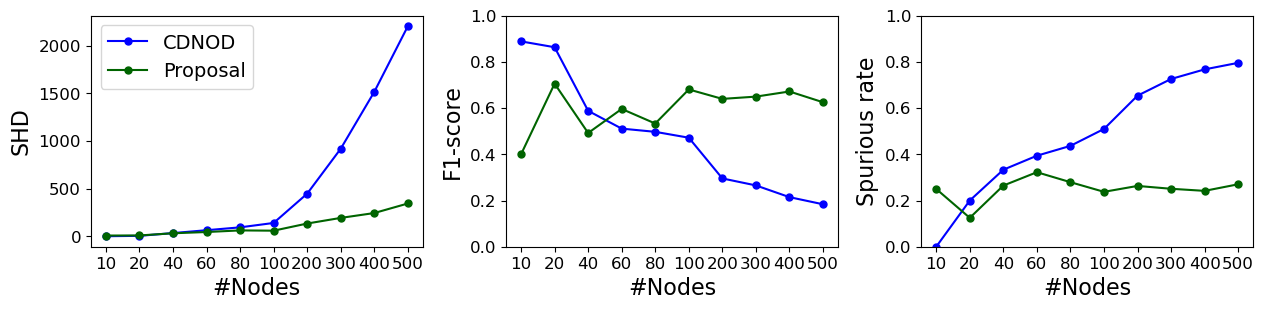

In [155]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 12})

fig, axes = plt.subplot_mosaic("ABC", figsize=(15, 3))

baselines = ["CDNOD", "Proposal"]
colors = ['blue', 'darkgreen', 'darkorange', 'red', 'cyan', 'brown']


metric = 'shd'
axes['A'].set_ylabel('SHD', fontsize=16)
axes['A'].set_xlabel("#Nodes", fontsize=16)
for algo in baselines:
    axes['A'].plot(xaxis, summary_csv[summary_csv['baseline'] == algo][metric], 
            markersize=5, marker='o', linewidth=1.5, linestyle='-', label=algo, color=colors[baselines.index(algo)])
axes['A'].legend(loc="upper left", fontsize=14)

metric = 'F1'
axes['B'].set_ylabel('F1-score', fontsize=16)
axes['B'].set_xlabel("#Nodes", fontsize=16)
axes['B'].set_ylim(0,1)
for algo in baselines:
    axes['B'].plot(xaxis, summary_csv[summary_csv['baseline'] == algo][metric], 
            markersize=5, marker='o', linewidth=1.5, linestyle='-', label=algo, color=colors[baselines.index(algo)])
    

metric = 'spuriousness'
axes['C'].set_ylabel('Spurious rate', fontsize=16)
axes['C'].set_xlabel("#Nodes", fontsize=16)
axes['C'].set_ylim(0,1)
for algo in baselines:
    axes['C'].plot(xaxis, summary_csv[summary_csv['baseline'] == algo][metric], 
            markersize=5, marker='o', linewidth=1.5, linestyle='-', label=algo, color=colors[baselines.index(algo)])


plt.subplots_adjust(wspace=0.25)